# 1. This Notebook

In this notebook I'll go through some calculations I have done to look at bias to get you started. Please go through the notebook, and make sure you understand what's here. You might decide there is a better way to go about some of these steps, so please feel encouraged to explore a bit!

Once you are comfortable with this analysis, you will find some different simulations online, and run a similar analysis. The goal is to see if you get similar results with different simulations, regardless of the assumptions that went into the modelling. Most importantly, we want to quantify the uncertainty in $H_0$ from this.

### Data
I've made a [Google Drive link](https://drive.google.com/open?id=1A1-G76jVrdVWhzbMFtq8tGwyNVlydSkM&usp=drive_fs) to share data I used in the notebook. 

### Packages/Dependencies (you will need to install to run the notebook)
1. [Pylians](https://pylians3.readthedocs.io/en/master/index.html)  + dependencies
2. pandas - you can read in the data using standard numpy libraries if you prefer, but I like pandas :)




# 2. Background



## Density perturbations

The density fluctuations at any point $r$ are given by
\begin{equation}
\delta(\mathbf{r}) = \dfrac{\rho(\mathbf{r}) - \bar{\rho}}{\bar{\rho}}
\end{equation}
where $\bar{\rho}$ is the average density.

In the linear regime, density perturbations are small; i.e. $\delta \ll 1$. With this assumption, you can analyze growth of structure using linear perturbation theory. 


## Measuring Peculiar Velocities 

*This follows Hollinger et al. 2012.*

From linear perturbation theory, the velocity field at any point is related to the matter density, $\delta = (\rho - \bar{\rho})/\bar{\rho}$:

\begin{equation}
\mathbf{v}(\mathbf{r}) = \dfrac{H_0 f(\Omega_m)}{4 \pi} \int \delta(\mathbf{r}) \dfrac{\mathbf{r}' - \mathbf{r}}{|\mathbf{r}'-\mathbf{r}|^3}\rm{d}^3 \mathbf{r}'
\end{equation}

where $f(\Omega_M) \approx \Omega_M^{0.55}$ for $\Lambda$CDM  (e.g. Wang+ 1998, Hudson+ 2012). In this equation, it is assumed that the distance is in units of km/s (i.e. $r = HR$, where $H$ is the Hubble parameter and $R$ is the comoving distance in Mpc). 


We are going to assume that the density field of a tracer, $\delta_t$ is related to the underlying density field through the linear equation $\delta_t = b_t \delta$, where $b_t$ is the linear bias.
Additionally, we will also define $\beta_x = f/b_x$. Then the velocity field measured from a (smoothed!) density tracer is:

\begin{equation}
\mathbf{v}(\mathbf{r}) = \dfrac{H_0 \beta_t}{4 \pi} \int \delta_t(\mathbf{r}) \dfrac{\mathbf{r}' - \mathbf{r}}{|\mathbf{r}'-\mathbf{r}|^3}\rm{d}^3 \mathbf{r}'
\end{equation}

However, we don't know $\beta_t$. Therefore, define:

\begin{equation}
\mathbf{v}_{\rm pred}(\mathbf{r}) = \dfrac{H_0}{4 \pi} \int \delta_{t}(\mathbf{r}) \dfrac{\mathbf{r}' - \mathbf{r}}{|\mathbf{r}'-\mathbf{r}|^3}\rm{d}^3 \mathbf{r}'
\end{equation}

which can be calculated from the density tracer. This can be compared to the velocities of a velocity tracer, $v_t$

\begin{equation}
\mathbf{v_t} = \beta_t \mathbf{v}_{\rm pred} \,\,\, ,
\end{equation}

and $\beta$ can be found from linear regression. 

You have a choice of both density tracers and velocity tracers (e.g. simulation particles, dark matter halos, galaxies).

So using this method, the main steps to get a velocity field are
1. Use a density tracer to get $\mathbf{v}_{\rm pred}$
2. Use a velocity tracer and $\mathbf{v}_{\rm pred}$ to get $\beta_t$
3. Multiply $\mathbf{v}_{\rm pred}$ by $\beta_t$ to get the velocity field everywhere

## Assumptions

There are (at least) three main assumptions that go into this. They have similar names, so careful not to confuse them with each other!

1. **Linear perturbation theory**: That $\delta$ is sufficiently small so that linear perturbation theory is valid, and our equation for $\mathbf{v}(\mathbf{r})$ holds. In order for this to be true, we will need to smooth the density field (discussed more below)

2. **Linear bias assumption**: One potential source for error is the assumption that the bias is linear: e.g. a higher order relationship might look something like: $\delta_g = b_1 \delta + b_2 \delta^2 + ...$

3. **Assembly bias**: Galaxy assembly bias refers to the fact that at fixed halo mass, galaxy properties and abundance may depend on secondary halo properties (e.g. Zentner+ 2014). The linear bias, $b$, can be a function of galaxy properties, redshift, ect. I suggest the Wechsler&Tinker review to learn more about this. In  [Carrick et al 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.450..317C) they express $b$ as a linear function in luminosity, which allows for galaxies to cluster differently as a function of their luminosity. This should indirectly capture some assembly bias, as luminous galaxies tend to live in more dense environments. However, this does not directly count for, e.g. environmental effects. 


### Long-term goal: quantify how assumptions about the bias factor (mainly linear bias and assembly bias) affect $H_0$ measurements


# 3. Calculating the Density Field - From Dark Matter Particles

## Simulation Data

The nice thing about simulations is that we can measure the density field exactly if we know where all the dark matter is --- this is something we will never be able to do with observations. For some of the simulations we will look at online, you might not have access to the full dark matter particle data. In this case you can probably get a good estimation from dark matter halo catalogs. This is something to think about, and look into further when we get to that step!

For this notebook, I included a snapshot from a dark-matter-only simulation that I ran. You can download this from the Google Drive ('snapshot_500'). It was run using the software Gadget-2, and is output in their specific binary format. 

More detail if needed: the simulated data is based on a dark matter simulation with $512^3$ particles, in a co-moving volume of  $(115 h^{-1} Mpc)^3$,  with a Planck 2018 cosmology, at redshift $z$. Initial conditions were created in Music , and the simulations are run in Gadget-2. Halo catalogs and merger trees using Rockstar and Consistent-trees


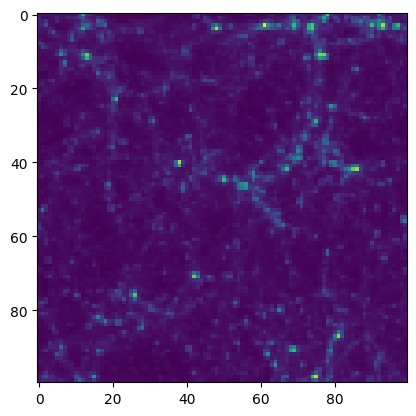

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MAS_library as MASL

##Read in the snapshot data 

snapshot = 'snapshot_500'          #name of Gadget file
ptypes = [1]                       #this specifies that the simulation only contains dark matter particles
grid = 100                       #this is how you specify the size of your density grid (I just made it 100x100)
MAS      = 'CIC'                   #Cloud-in-Cell. This is the interpolation scheme we are using to calculate the density
do_RSD   = False                   #dont do redshif-space distortions
axis     = 0                       #axis along which place RSD; not used here
verbose  = False   #whether print information on the progress


# Compute the effective number of particles/mass in each voxel
delta = MASL.density_field_gadget(snapshot, ptypes, grid, MAS, do_RSD, axis, verbose)

# compute density contrast: delta = rho/<rho> - 1
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

#Quick Check
plt.imshow(np.mean(delta,axis=0)) #plot the density field

Okay, this looks like the cosmic web!

Note that we could make this plot *way* prettier. This is the same simulation that is plotted in the proposal we sent you. However, for now this is good for a sanity check. If you need to plot some simulation data later for talks/papers, I can give you some tips on how to make it look nicer :)

## Smoothing

We actually can't use this density field directly --- we need to smooth it first. This is because linear perturbation does not hold on small scales. However there is a drawback to smoothing the density field, since it effectively washes out the signal. 

Smoothing requires picking some size of filter (generally a top-hat filter), and convolving our density field with it. If you pick a filter that is too small, linear perturbation is no longer applicable. If you pick a filter that's too large, you supress the density contrasts and velocities are underpredicted.

It turns out that smoothing on scales of 4$h^{-1}$ Mpc gives us the best results (see disscusion and results in the Appendix A1 in [Carrick et al 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.450..317C))



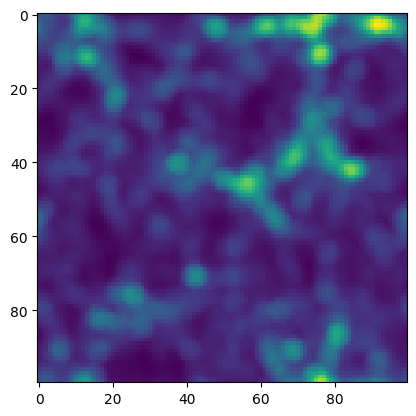

In [2]:
import smoothing_library as SL

BoxSize = 115  #from simulation params. Mpc/h 
R = 4       #smoothing kernalMpc/h
grid = delta.shape[0]
Filter  = 'Top-Hat' #type of smoothing kernal 
threads = 8   #computer threads, for parallelization 

# compute FFT of the filter
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)

# smooth the field
delta_smoothed = SL.field_smoothing(delta, W_k, threads)

#Quick Check
plt.imshow(np.mean(delta_smoothed,axis=0)) 


# 3. Calculating the Density Field - From Galaxies

For real observations, it is more likely that you will build your density field using galaxy tracers. If we have a density field from the dark matter, and a density field from the galaxies, we can measure the bias exactly. 

## Simulated Galaxy Data

Using the dark matter simulation above I created a "mock galaxy catalog". This is just a list of positions for the galaxies, and some properties for each. 

A galaxy was assigned to each dark matter halo in the simulation using abundance matching between dark matter halo peak circular velocity values and the K-band luminosity function from Lavaux+2011. 

I only included galaxies that are brighter than -20 mag in K band, which is similar to the survey used in Carrick+2015. Deciding which galaxies to include in the analysis is definitely something that could use some exploring!

Note that I used their number-weighted density, which give similar peculiar velocities to the more commonly used luminosity-weighted densities (e.g. Carrick+2015). I chose to use number-weighted density, because it will give a more straightforward comparison to the linear bias calculated from the correlation functions (more on this later). However, this may also be something worth exploring/thinking about. 



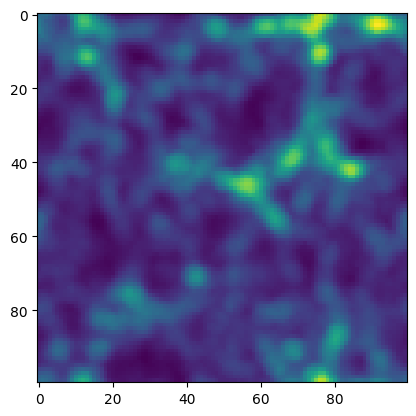

In [3]:
import pandas as pd

#Read in galaxy data
filename = 'galaxycat.csv'
galaxycat  = pd.read_csv(filename)
pos = galaxycat.loc[:,['x','y','z']].to_numpy(dtype=np.float32)

#Get density field
delta_g = np.zeros((grid,grid,grid), dtype=np.float32)
MASL.MA(pos, delta_g, BoxSize, MAS, verbose=False)
delta_g /= np.mean(delta_g, dtype=np.float64);  delta_g -= 1.0



# smooth the field
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
delta_g_smoothed = SL.field_smoothing(delta_g, W_k, threads)

#Quick Check
plt.imshow(np.mean(delta_g_smoothed,axis=0)) 



This looks almost identical to our density field from the dark matter particles! This is good news, it means that if we know galaxy locations, we can do a pretty good job at reconstructing the underlying dark matter density.

# 4. Calculating the Linear Bias Directly

Recall the linear bias, $b$, relates the density fluctuations in the galaxy distribution to those of the mass distribution
\begin{equation}
\delta_g = b \delta
\end{equation}


Therefore, we can calculate the bias in each pixel of this smooth density field as  

$b = \delta_g / \delta$


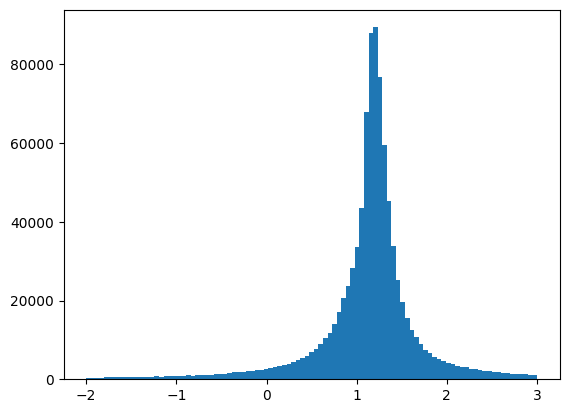

In [4]:
b = (delta_g_smoothed/delta_smoothed).flatten()

hist = plt.hist(b, bins = np.linspace(-2,3,100))

This histogram shoes the distribution of the bias parameter measured in each pixel. The median bias is a little over 1 --- however, there is a spread.

Since in practice you have the galaxy density field, and use a bias parameter to reconstruct the total matter density field, this means you could be getting the density off by a factor of 2 at some pixels. This might not matter if we don't need a peculiar velocity at that position. That is, these pixels might be areas that are pretty low density, and won't contain supernova. However, this is something we need to look into further. 

## Bias from 2pcf 

Since bias is commonly measured using the  2-point correlation function (2pcf) I wanted to go through the rough idea, but you might find you don't need to use this. 

The 2pcf $\xi \equiv \angle \delta \delta \rangle$ is the autocorrelation of $\delta$. It tells you how clustered something is on a certain scale. Suppose you have N points placed in some volume. If $\xi(r_i)=1$ that means that the number of points that are seperated by a distance $r_i$ is exactly what you would expect if all the points were randomly placed. A bigger number means that at that scale there is more clustering (i.e. more points seperated by a distance $r_i$ than you would expect), where a smaller number means there is less clustering.

If you assume a linear bias, you can easily prove:
\begin{equation} \label{eq:linearbias}
b = \sqrt{\xi_g/ \xi}
\end{equation}



First, let's plot the 2pcf for the dark matter. The package Pylians only supports calculating the 2pcf from density fields. More commonly, you would actually just use the galaxy positions to calculate the 2pcf directly. If you decide to explore this a bit more, I can point you to other packages, or talk over how to code it yourself. 




Computing correlation function of the field...
Time to complete loop = 0.00
Time taken = 0.13 seconds


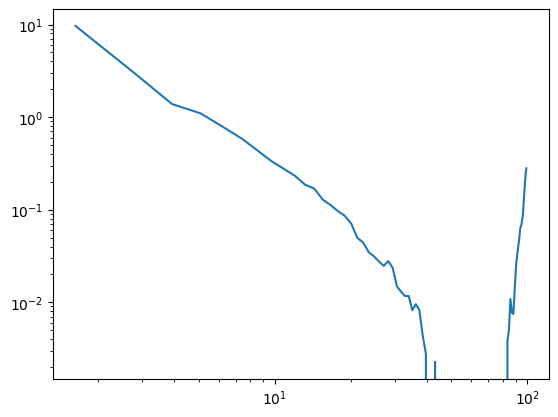

In [5]:
import Pk_library as PKL

# correlation function parameters
BoxSize = 115 #Mpc/h
MAS = 'CIC'
axis = 0

# compute the correlation function
CF = PKL.Xi(delta, BoxSize, MAS, axis, threads)

# get the attribute
r = CF.r3D #radii in Mpc/h
xi0 = CF.xi[:,0] #correlation function (monopole)

plt.loglog(r,xi0)

This shape is pretty characteristic for dark matter. There is much more clustering on small scales compared to large scales. Ignore the weird blip at high $r$... The simulation box is only $r=115$, so you won't be able to measure the 2pcf function well at these radii.

Doing the same thing for galaxies:


Computing correlation function of the field...
Time to complete loop = 0.00
Time taken = 0.11 seconds


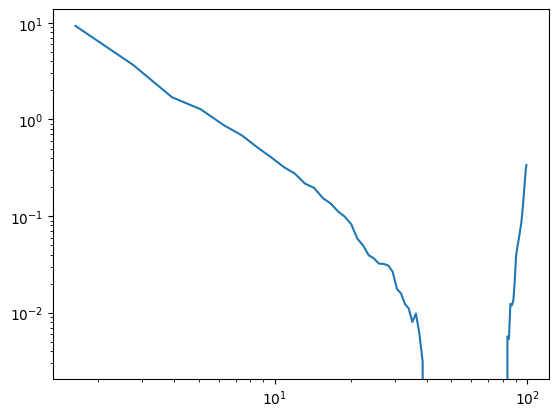

In [6]:
# correlation function parameters
BoxSize = 115 #Mpc/h
MAS = 'CIC'
axis = 0

# compute the correlation function
CF = PKL.Xi(delta_g, BoxSize, MAS, axis, threads)

# get the attribute
r_g = CF.r3D #radii in Mpc/h
xi0_g = CF.xi[:,0] #correlation function (monopole)

plt.loglog(r_g,xi0_g)

If we calculate the bias on scales R= 4 Mpc/h, we find

In [7]:
#interpolate
xi_g = np.interp(R,r_g, xi0_g)
xi = np.interp(R,r, xi0)

bias = np.sqrt(xi_g/xi)

print(bias)

1.1064006647638889


This value of 1.1 agrees well with the median in the histogram we plotted earlier!

# 5. Research Task (Assembly Bias)

Split the galaxies into different bins based on their properties (e.g. luminosity, environment, etc.). If we plot histograms of the bias in each of these bins, where do they fall on the above histogram? Are some populations of galaxies closer to the mean bias than others?

If we find a clear trend of which galaxies do/don't work well with the median bias assumption this may help us either (1) improve our velocity field estimates or at least (2) understand the uncertainties a bit better as a function of galaxy properties.

The next step would be to do this for other mock galaxy catalogs, and make sure we get the same results (and that it wasn't just because of assumptions that went into making the mock catalog!

# 6. Calculating Peculiar Velocity

I can give you code for calculating the peculiar velocity field later :) Reach out if you want it before then. 